In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
import time
import warnings
warnings.filterwarnings('ignore')

In [42]:
data = pd.read_csv('train.csv')

**График целевой переменной (с выбросами):**

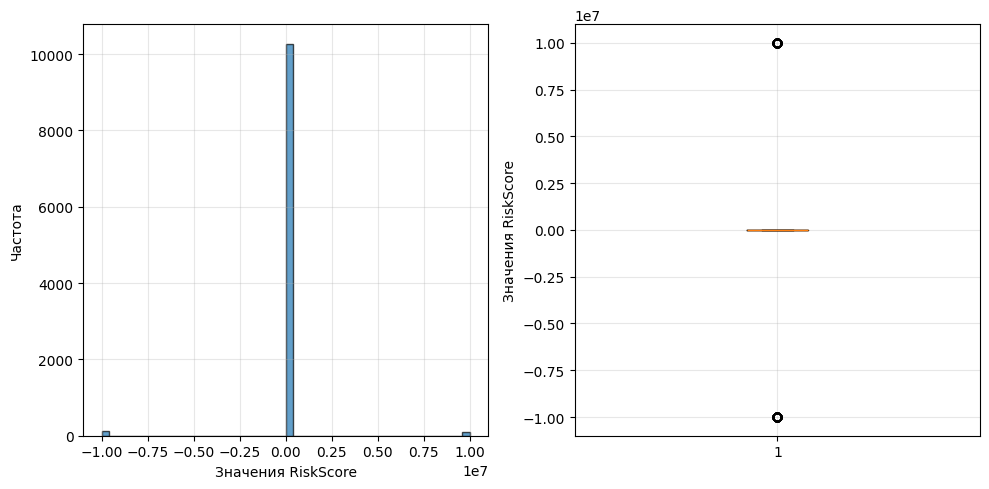

In [43]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(data['RiskScore'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Значения RiskScore')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(data['RiskScore'].dropna())
plt.ylabel('Значения RiskScore')
plt.grid(True, alpha=0.3)

plt.tight_layout()

In [44]:
data_copy = data.copy().drop('ApplicationDate', axis=1)

In [45]:
categorical_cols = data_copy.select_dtypes(include=['object', 'category']).columns

data_copy = pd.get_dummies(data_copy, columns=categorical_cols)

data_copy = data_copy.astype(float)

**Матрица корреляций (с выбросами):**

In [46]:
corr_matrix = data_copy.corr()

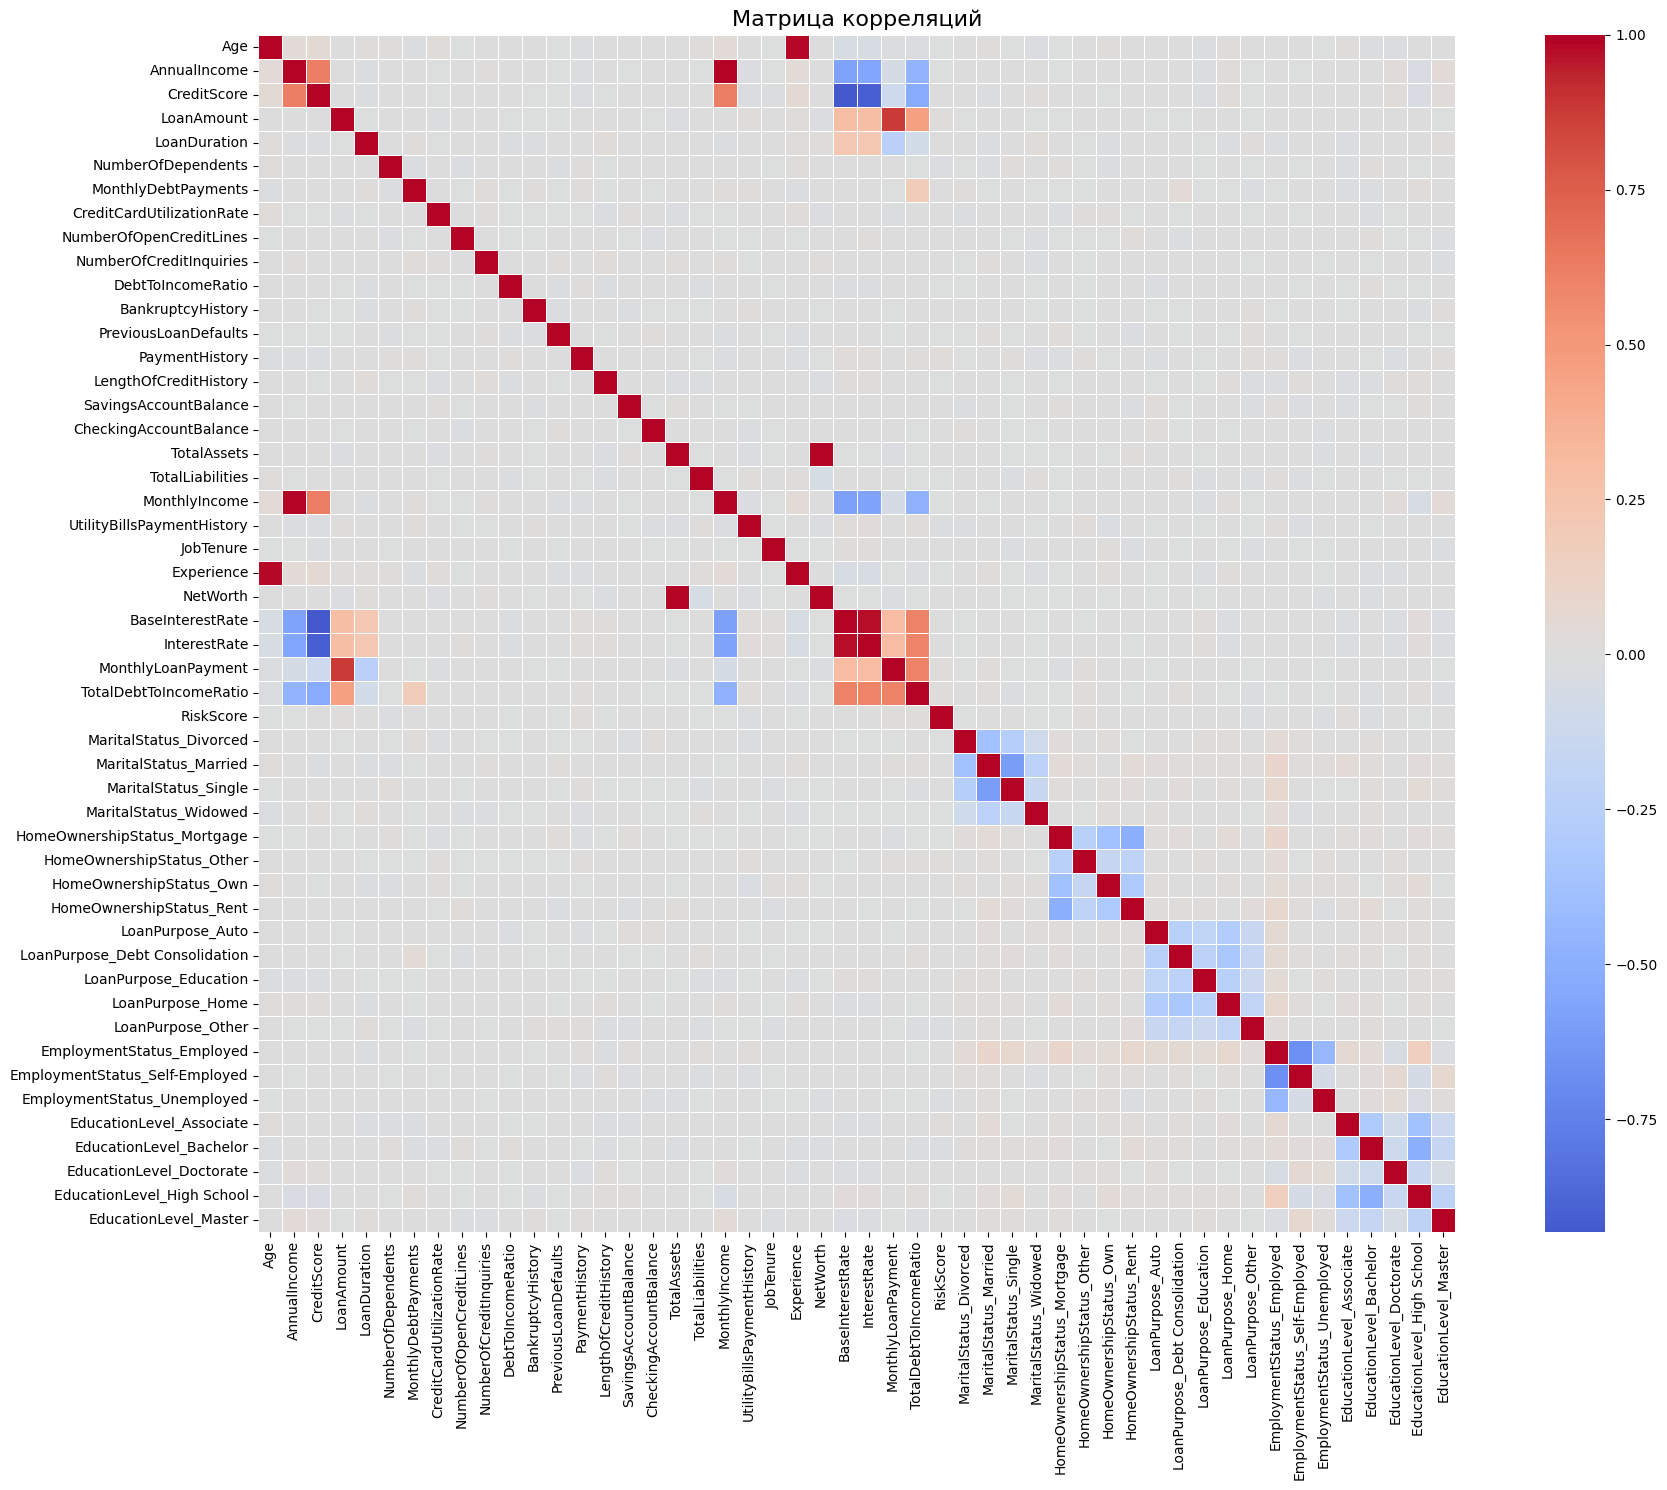

In [47]:
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Матрица корреляций', fontsize=16)

plt.tight_layout()

In [48]:
def drop_outliers(df, col=None, cutoff=6):
    df_copy = df.copy()

    if col is not None:
        numeric_cols = [col]
    else:
        numeric_cols = df_copy.select_dtypes(include=[np.number]).columns

    mask = pd.Series(False, index=df_copy.index)

    for ncol in numeric_cols:
        z_vals = (df_copy[ncol] - df_copy[ncol].mean()) / df_copy[ncol].std()
        mask = mask | (z_vals.abs() > cutoff)

    return df_copy[~mask]

In [49]:
def impute_missing_data(df):
    result = df.copy()

    num_cols = result.select_dtypes(include=[np.number]).columns
    if 'RiskScore' in num_cols:
        num_cols = num_cols.drop('RiskScore')

    result[num_cols] = result[num_cols].fillna(result[num_cols].median())

    return result

In [50]:
data_clean = drop_outliers(data_copy, cutoff=6)
data_clean = data_clean.dropna(subset=['RiskScore'])
data_clean = impute_missing_data(data_clean)

**График целевой переменной (без выбросов):**

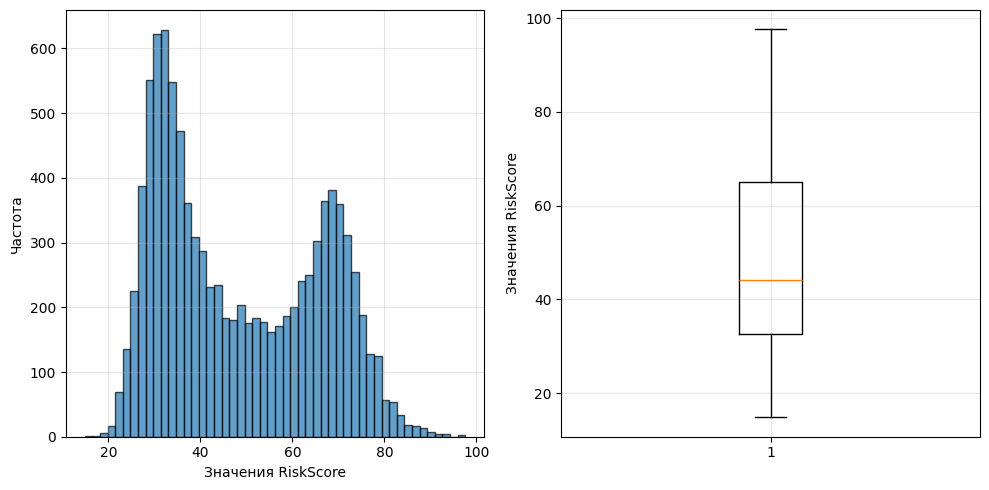

In [51]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(data_clean['RiskScore'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Значения RiskScore')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(data_clean['RiskScore'])
plt.ylabel('Значения RiskScore')
plt.grid(True, alpha=0.3)

plt.tight_layout()

**Матрица корреляций (без выбросов):**

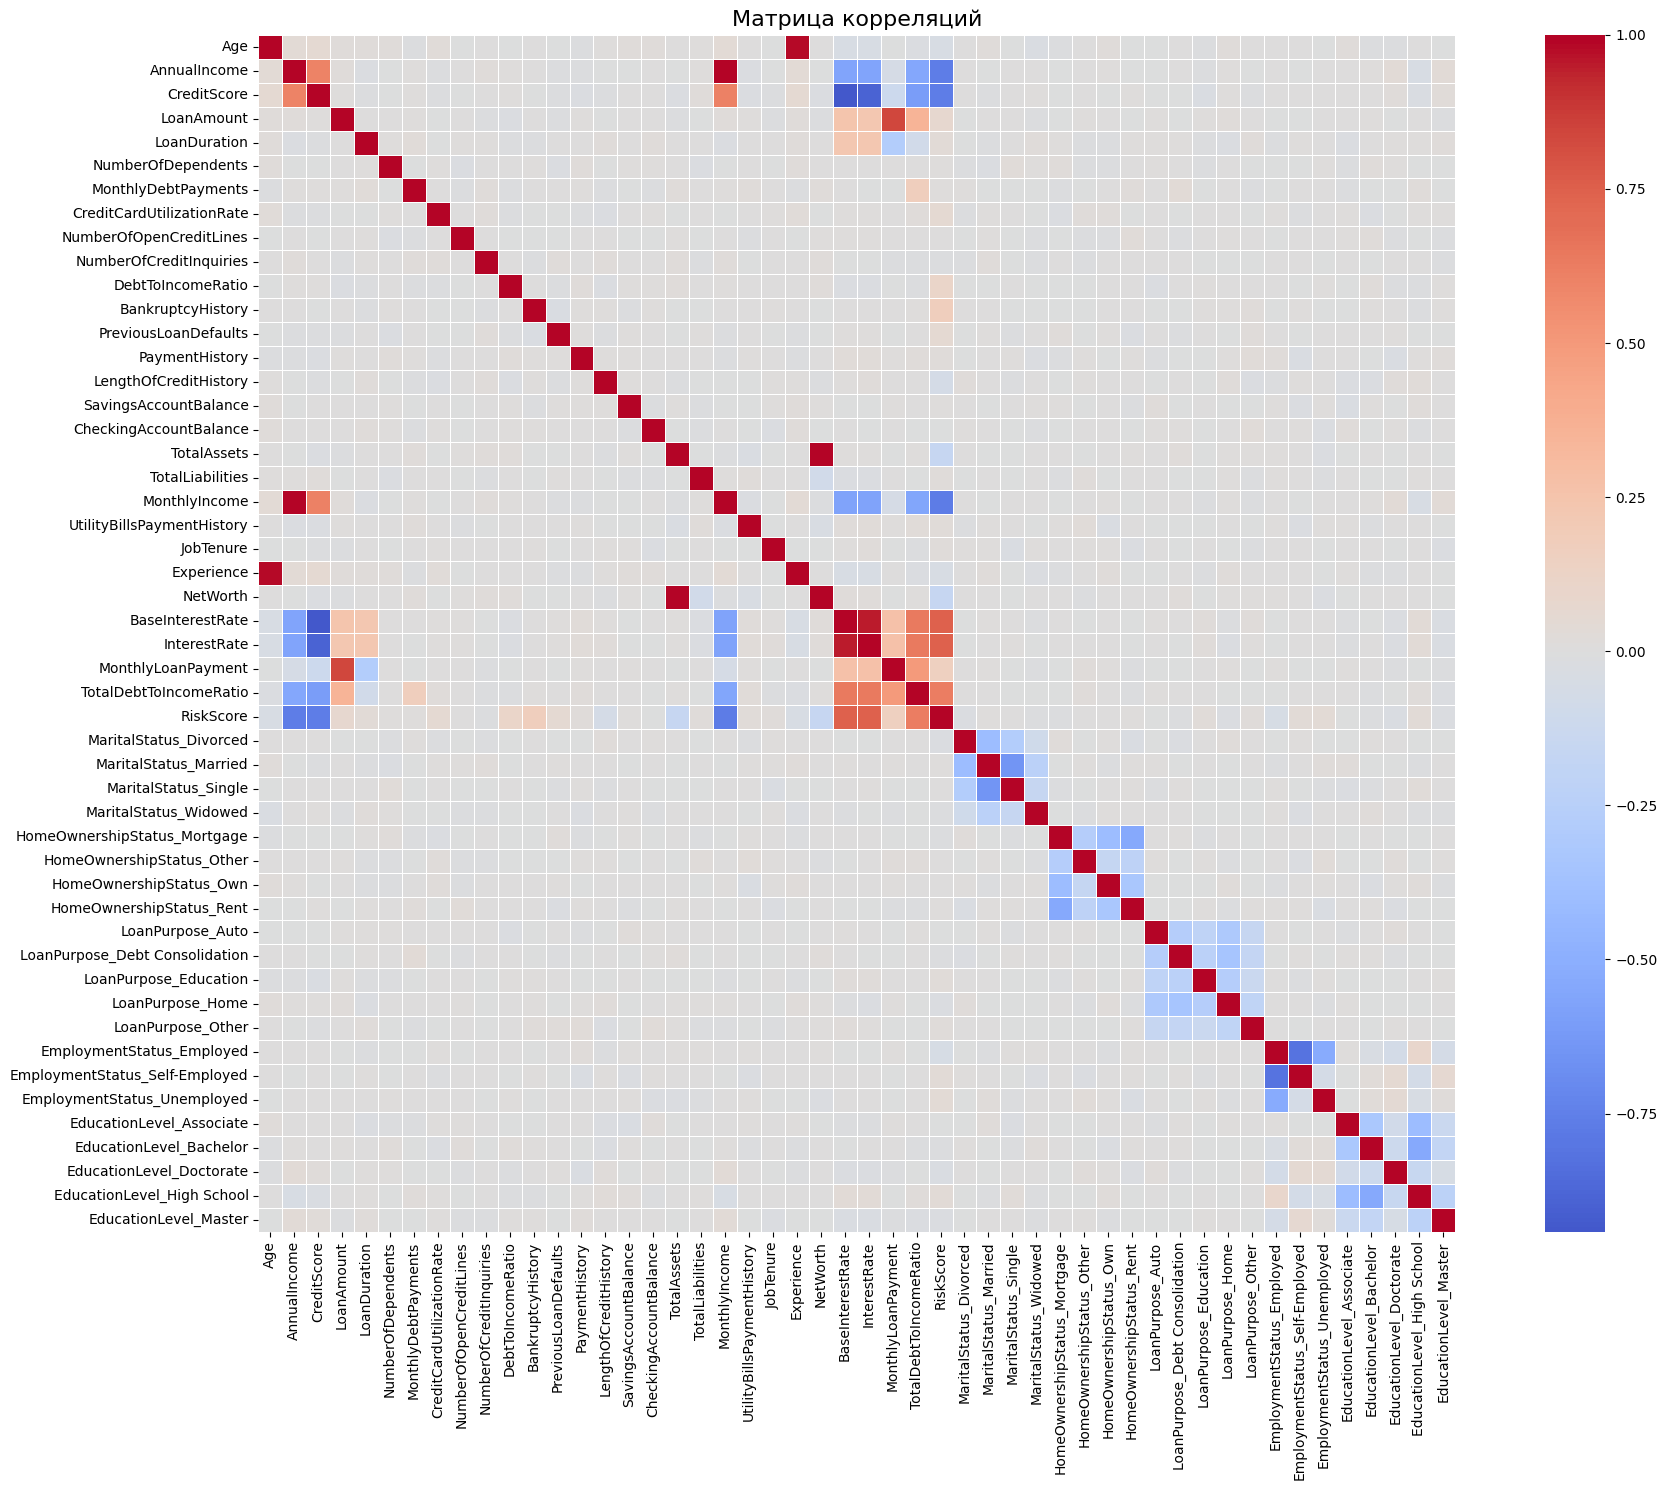

In [52]:
corr_matrix = data_clean.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Матрица корреляций', fontsize=16)

plt.tight_layout()

In [53]:
class DataNormalizer:
  def __init__(self, method='zscore'):
    self.method = method
    self.params = {}

  def fit(self, X):
    if self.method == 'zscore':
      self.params['mean'] = X.mean()
      self.params['std'] = X.std()
    elif self.method == 'minmax':
      self.params['min'] = X.min()
      self.params['max'] = X.max()
    else:
      raise ValueError()

  def transform(self, X):
    if self.method == 'zscore':
      return (X - self.params['mean']) / self.params['std']
    elif self.method == 'minmax':
      return (X - self.params['min']) / (self.params['max'] - self.params['min'])

  def fit_transform(self, X):
    self.fit(X)
    return self.transform(X)

  def inverse_transform(self, X_normalized):
    if self.method == 'zscore':
      return X_normalized * self.params['std'] + self.params['mean']
    elif self.method == 'minmax':
      return X_normalized * (self.params['max'] - self.params['min']) + self.params['min']

In [54]:
data_normalized_zscore = data_clean.copy()
data_normalized_minmax = data_clean.copy()

zscore_normalizer = DataNormalizer(method='zscore')
minmax_normalizer = DataNormalizer(method='minmax')

for feature in data_clean.columns:
  zscore_normalizer.fit(data_clean[feature])
  data_normalized_zscore[feature] = zscore_normalizer.transform(data_clean[feature])

  minmax_normalizer.fit(data_clean[feature])
  data_normalized_minmax[feature] = minmax_normalizer.transform(data_clean[feature])

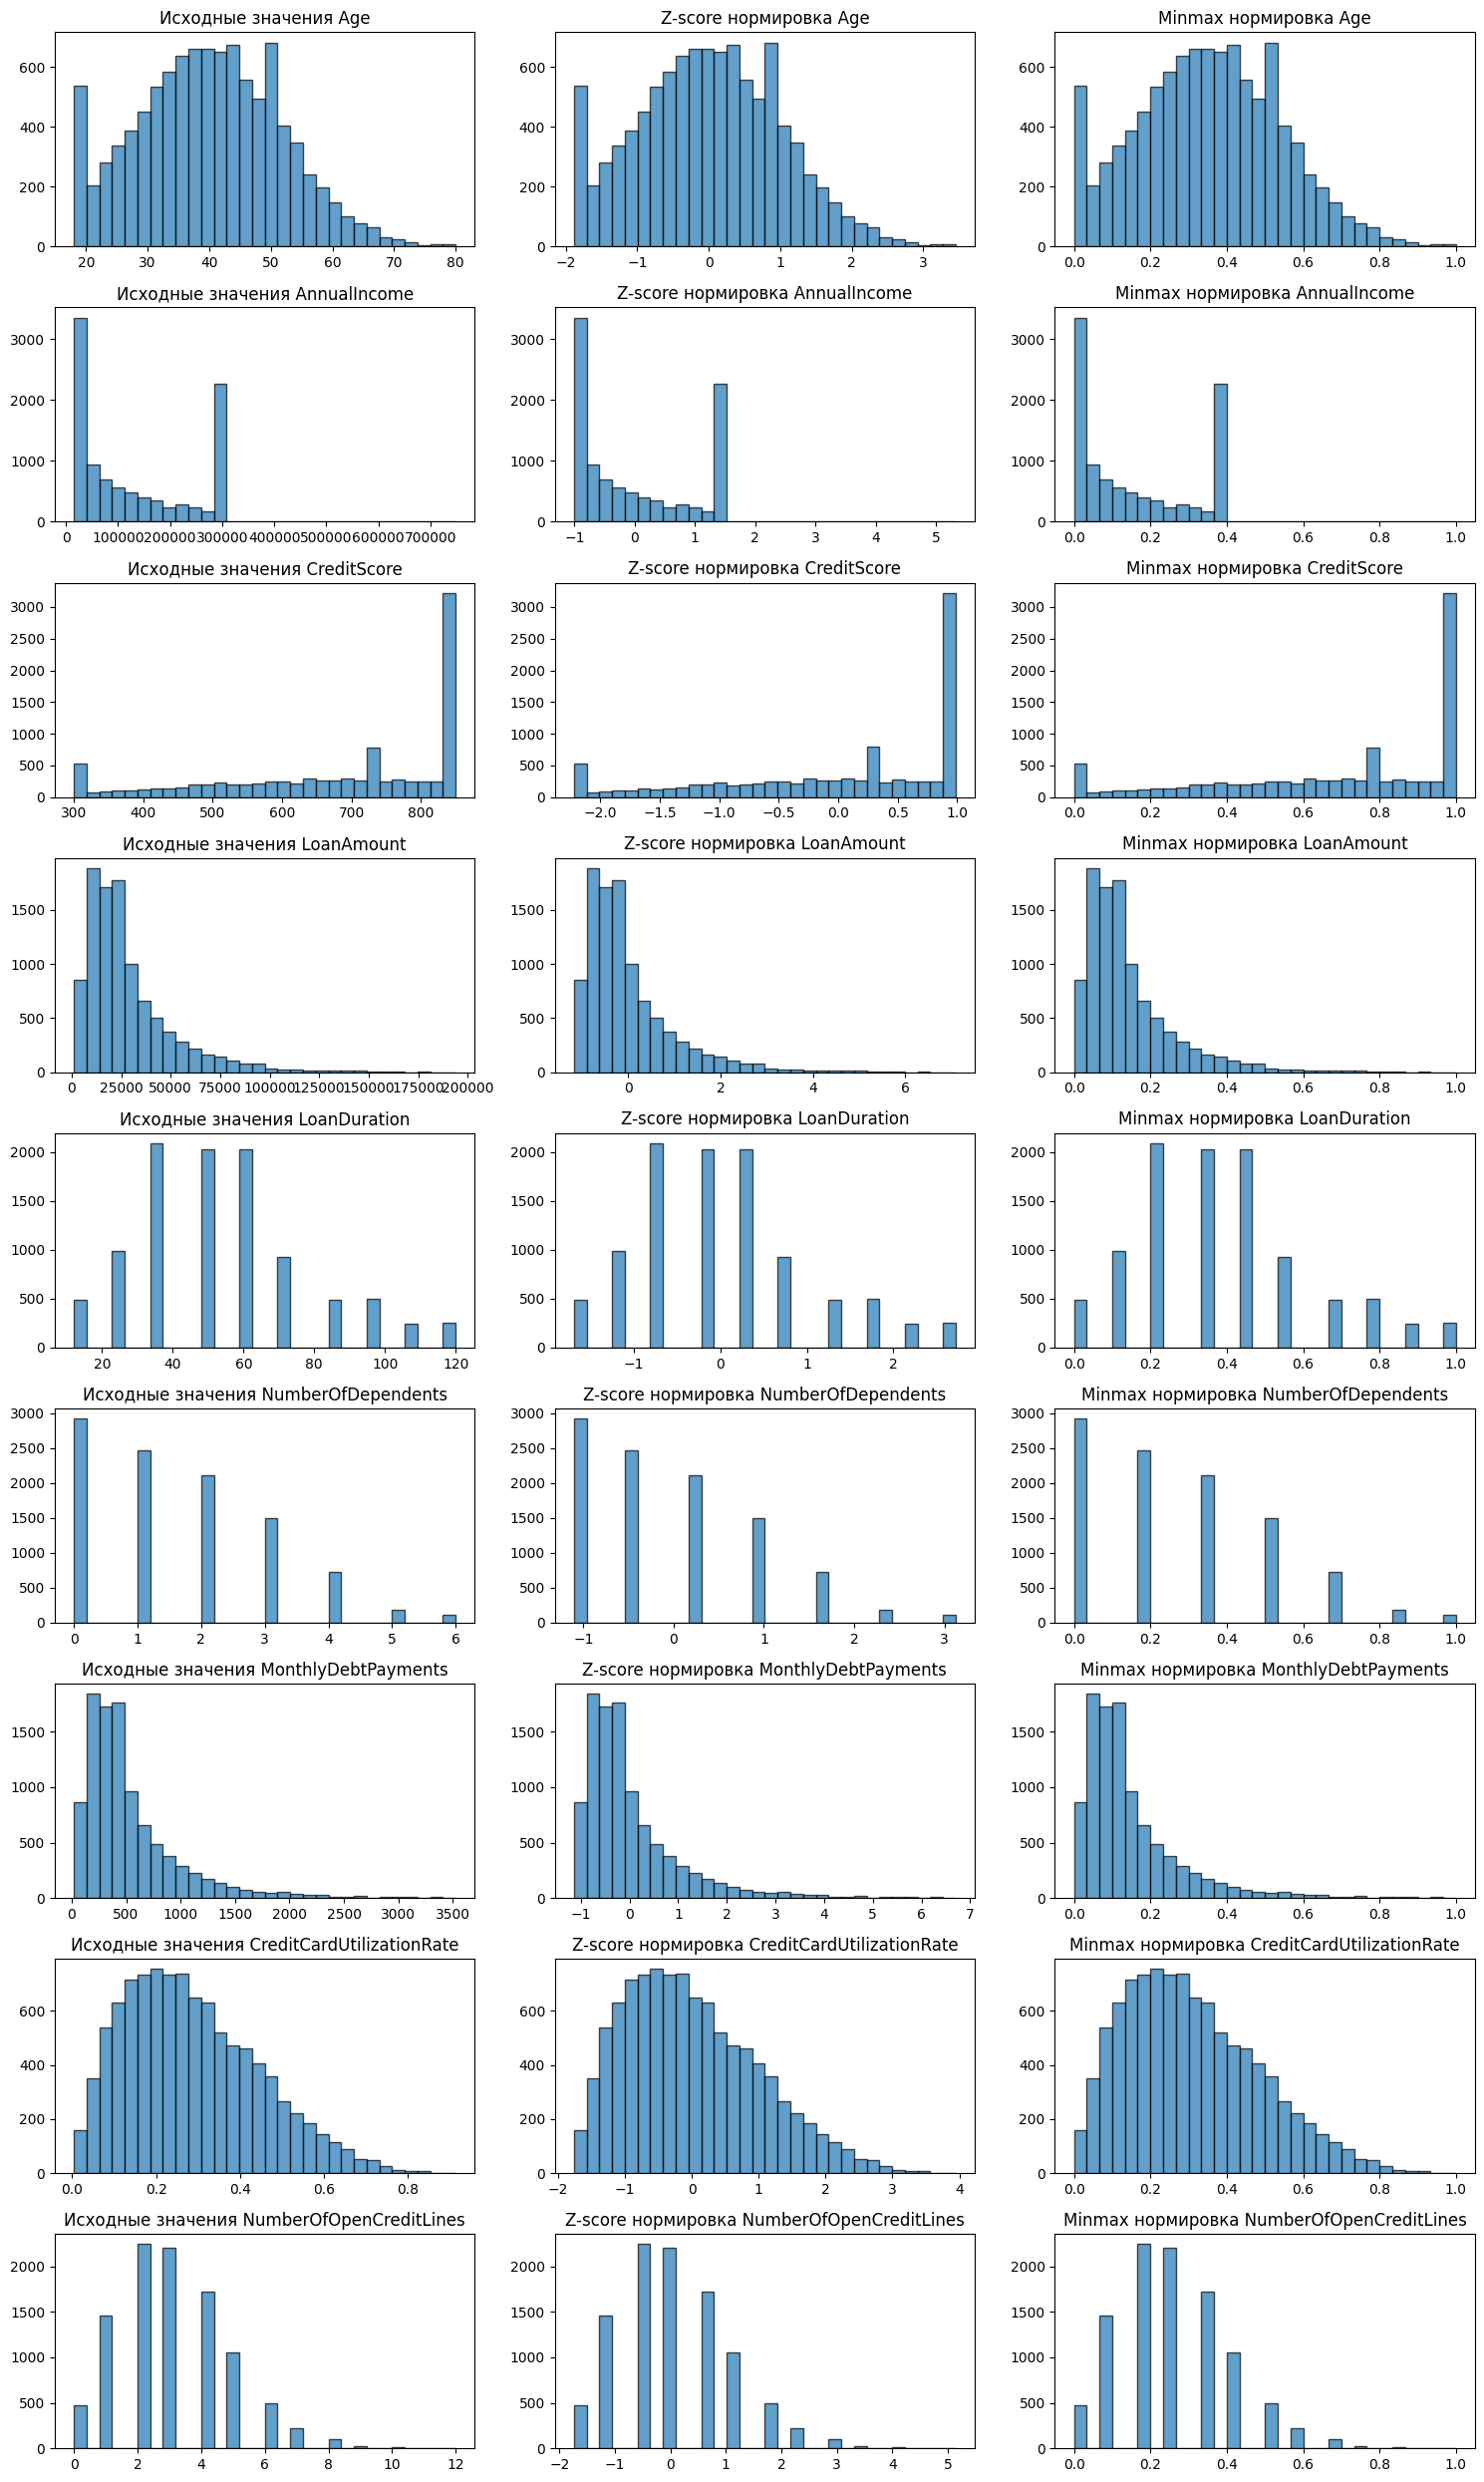

In [55]:
sample_features = data_clean.columns[:9]

plt.figure(figsize=(15, 25))

for i, feature in enumerate(sample_features):
  plt.subplot(len(sample_features), 3, i * 3 + 1)
  plt.hist(data_clean[feature], bins=30, edgecolor='black', alpha=0.7)
  plt.title(f"Исходные значения {feature}")

  plt.subplot(len(sample_features), 3, i * 3 + 2)
  plt.hist(data_normalized_zscore[feature], bins=30, edgecolor='black', alpha=0.7)
  plt.title(f"Z-score нормировка {feature}")

  plt.subplot(len(sample_features), 3, i * 3 + 3)
  plt.hist(data_normalized_minmax[feature], bins=30, edgecolor='black', alpha=0.7)
  plt.title(f"Minmax нормировка {feature}")

plt.tight_layout()

In [56]:
X_norm = data_normalized_zscore.drop('RiskScore', axis=1).values
y_norm = data_clean['RiskScore'].values

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)


In [57]:
class LinearRegression:
    def __init__(self, fit_intercept=True):
        self.weights = None
        self.fit_intercept = fit_intercept

    def _prepare_X(self, X):
        if self.fit_intercept:
            if self.weights is None or X.shape[1] == len(self.weights) - 1:
                return np.c_[np.ones(X.shape[0]), X]
            elif X.shape[1] == len(self.weights):
                return X
        else:
            if self.weights is not None and X.shape[1] != len(self.weights):
                raise ValueError()
            return X

        expected = len(self.weights) - (1 if self.fit_intercept else 0)
        raise ValueError()

    def predict(self, X):
        if self.weights is None:
            raise ValueError()

        X_prepared = self._prepare_X(X)

        if X_prepared.shape[1] != len(self.weights):
            raise ValueError()

        return X_prepared @ self.weights

    def fit_analytical(self, X, y, regularization_param=0.0):
        X_b = self._prepare_X(X)
        n_features = X_b.shape[1]

        if regularization_param > 0:
            reg_matrix = regularization_param * np.eye(n_features)
            reg_matrix[0][0] = 0
            self.weights = np.linalg.pinv(X_b.T @ X_b + reg_matrix) @ X_b.T @ y
        else:
            self.weights = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y

        return self

    def fit_gradient_descent(self, X, y, learning_rate=0.01, n_iterations=1000, regularization_param=0.0):
        X_b = self._prepare_X(X)
        n_samples = X_b.shape[0]
        self.weights = np.random.randn(X_b.shape[1])

        for iteration in range(n_iterations):
            predictions = X_b @ self.weights
            errors = predictions - y
            gradients = (2/n_samples) * X_b.T @ errors

            if regularization_param > 0:
                gradients += (2 * regularization_param / n_samples) * self.weights

            self.weights -= learning_rate * gradients

        return self

    def fit_stochastic_gradient_descent(self, X, y, learning_rate=0.01, n_iterations=1000, batch_size=32, regularization_param=0.0):
        X_b = self._prepare_X(X)
        n_samples = X_b.shape[0]
        self.weights = np.random.randn(X_b.shape[1])

        for _ in range(n_iterations):
            indices = np.random.permutation(n_samples)
            X_shuffled = X_b[indices]
            y_shuffled = y[indices]

            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                predictions = X_batch @ self.weights
                errors = predictions - y_batch
                gradients = (2/len(X_batch)) * X_batch.T @ errors

                if regularization_param > 0:
                    gradients += (2 * regularization_param / len(X_batch)) * self.weights

                self.weights -= learning_rate * gradients

        return self

In [58]:
model_analytical = LinearRegression()
model_analytical.fit_analytical(X_train_norm, y_train_norm)

y_pred_analytical = model_analytical.predict(X_test_norm)

mse_analytical = mean_squared_error(y_test_norm, y_pred_analytical)

In [59]:
model_gd = LinearRegression()
model_gd.fit_gradient_descent(X_train_norm, y_train_norm, learning_rate=0.01, n_iterations=1000)

y_pred_gd = model_gd.predict(X_test_norm)

mse_gd = mean_squared_error(y_test_norm, y_pred_gd)

In [60]:
model_sgd = LinearRegression()
model_sgd.fit_stochastic_gradient_descent(X_train_norm, y_train_norm, learning_rate=0.01, n_iterations=1000, batch_size=32)

y_pred_sgd = model_sgd.predict(X_test_norm)

mse_sgd = mean_squared_error(y_test_norm, y_pred_sgd)

In [61]:
sklearn_model_analytical = SklearnLinearRegression()
sklearn_model_analytical.fit(X_train_norm, y_train_norm)

y_pred_sklearn_analytical = sklearn_model_analytical.predict(X_test_norm)

mse_sklearn_analytical = mean_squared_error(y_test_norm, y_pred_sklearn_analytical)

In [62]:
sklearn_model_sgd = SGDRegressor(max_iter=1000, eta0=0.001, learning_rate='constant', penalty='l2', random_state=42)
sklearn_model_sgd.fit(X_train_norm, y_train_norm)

y_pred_sklearn_sgd = sklearn_model_sgd.predict(X_test_norm)

mse_sklearn_sgd = mean_squared_error(y_test_norm, y_pred_sklearn_sgd)

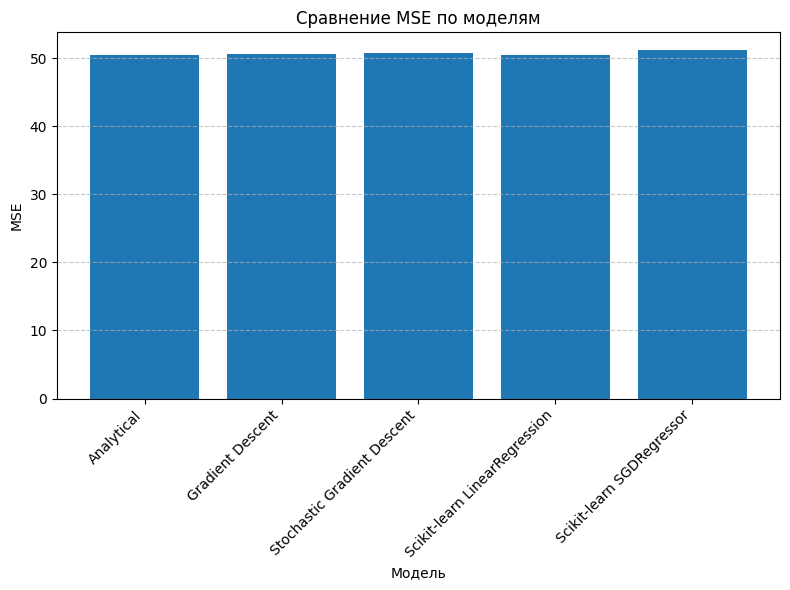

In [63]:
mse_values = [mse_analytical, mse_gd, mse_sgd, mse_sklearn_analytical, mse_sklearn_sgd]
models = ['Analytical', 'Gradient Descent', 'Stochastic Gradient Descent', 'Scikit-learn LinearRegression', 'Scikit-learn SGDRegressor']

plt.figure(figsize=(8, 6))
plt.bar(models, mse_values)
plt.title('Сравнение MSE по моделям')
plt.xlabel('Модель')
plt.ylabel('MSE')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

In [64]:
def kfold_cv(X, y, k=5, model_class=LinearRegression):
  kf_mse_scores = []

  shuffled_indices = np.random.permutation(len(X))
  fold_size = len(X) // k

  for i in range(k):
    test_start = i * fold_size
    test_end = (i + 1) * fold_size

    if i == k - 1:
      test_indices = shuffled_indices[test_start:]
    else:
      test_indices = shuffled_indices[test_start:test_end]

    train_indices = np.setdiff1d(shuffled_indices, test_indices)

    X_train_fold = X[train_indices]
    y_train_fold = y[train_indices]
    X_test_fold = X[test_indices]
    y_test_fold = y[test_indices]

    model_kf = model_class()
    model_kf.fit_analytical(X_train_fold, y_train_fold)

    X_test_fold_intercept = np.c_[np.ones(X_test_fold.shape[0]), X_test_fold]
    y_pred_fold = model_kf.predict(X_test_fold_intercept)

    mse = mean_squared_error(y_test_fold, y_pred_fold)
    kf_mse_scores.append(mse)

  avg_mse = np.mean(kf_mse_scores)
  return avg_mse, kf_mse_scores

def loo_cv(X, y, model_class=LinearRegression, max_samples=100):
  loo_mse_scores = []
  n_samples = len(X)

  if n_samples > max_samples:
    loo_indices_to_run = range(max_samples)
  else:
    loo_indices_to_run = range(n_samples)

  for i in loo_indices_to_run:
    X_test_loo = X[i:i+1]
    y_test_loo = y[i:i+1]

    X_train_loo = np.delete(X, i, axis=0)
    y_train_loo = np.delete(y, i, axis=0)

    model_loo = model_class()
    model_loo.fit_analytical(X_train_loo, y_train_loo)

    X_test_loo_intercept = np.c_[np.ones(X_test_loo.shape[0]), X_test_loo]
    y_pred_loo = model_loo.predict(X_test_loo_intercept)

    mse = mean_squared_error(y_test_loo, y_pred_loo)
    loo_mse_scores.append(mse)

  avg_mse = np.mean(loo_mse_scores)
  return avg_mse, loo_mse_scores

In [65]:
avg_mse_kfold, kf_mse_scores = kfold_cv(X_norm, y_norm, k=5, model_class=LinearRegression)
avg_mse_loo, loo_mse_scores = loo_cv(X_norm, y_norm, model_class=LinearRegression, max_samples=100)

In [66]:
def sklearn_kfold_cv(X, y, k=5):
  kf = KFold(n_splits=k, shuffle=True, random_state=42)
  kf_mse_scores = []

  for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = SklearnLinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    kf_mse_scores.append(mse)

  avg_mse = np.mean(kf_mse_scores)
  return avg_mse, kf_mse_scores

def sklearn_loo_cv(X, y, max_samples=100):
  loo = LeaveOneOut()
  loo_mse_scores = []

  if len(X) > max_samples:
    X_subset = X[:max_samples]
    y_subset = y[:max_samples]
  else:
    X_subset = X
    y_subset = y

  for i, (train_index, test_index) in enumerate(loo.split(X_subset)):
    X_train, X_test = X_subset[train_index], X_subset[test_index]
    y_train, y_test = y_subset[train_index], y_subset[test_index]

    model = SklearnLinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    loo_mse_scores.append(mse)

  avg_mse = np.mean(loo_mse_scores)
  return avg_mse, loo_mse_scores

In [67]:
avg_mse_sklearn_kfold, sklearn_kf_mse_scores = sklearn_kfold_cv(X_norm, y_norm, k=5)
avg_mse_sklearn_loo, sklearn_loo_mse_scores = sklearn_loo_cv(X_norm, y_norm, max_samples=1000)

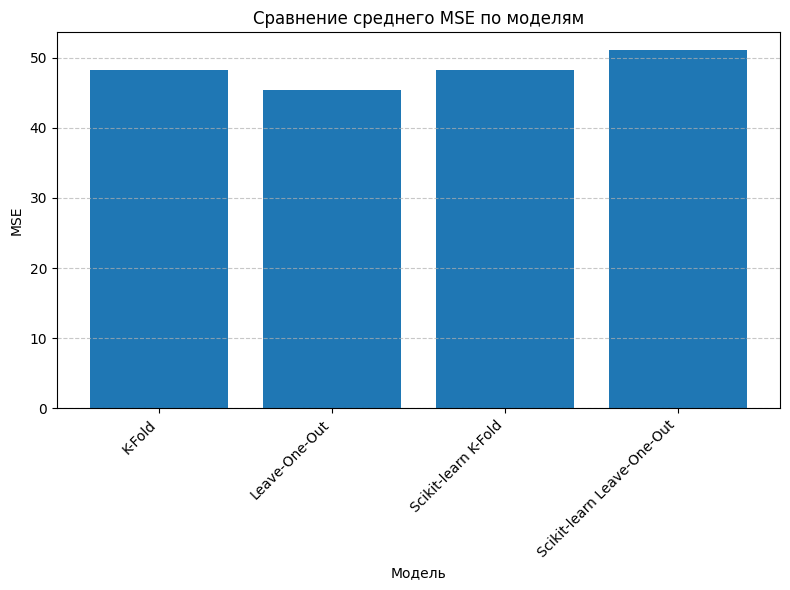

In [68]:
mse_values = [avg_mse_kfold, avg_mse_loo, avg_mse_sklearn_kfold, avg_mse_sklearn_loo]
models = ['K-Fold', 'Leave-One-Out', 'Scikit-learn K-Fold', 'Scikit-learn Leave-One-Out']

plt.figure(figsize=(8, 6))
plt.bar(models, mse_values)
plt.title('Сравнение среднего MSE по моделям')
plt.xlabel('Модель')
plt.ylabel('MSE')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

In [69]:
def mse(y_true, y_pred):
  if len(y_true) != len(y_pred):
      raise ValueError()
  return np.mean((y_true - y_pred)**2)

In [70]:
print(f"MSE (Analytical model): {mse(y_test_norm, y_pred_analytical):.4f}")
print(f"Scikit-learn MSE (Analytical model): {mean_squared_error(y_test_norm, y_pred_analytical):.4f}")
print()
print(f"MSE (GD model): {mse(y_test_norm, y_pred_gd):.4f}")
print(f"Scikit-learn MSE (GD model): {mean_squared_error(y_test_norm, y_pred_gd):.4f}")
print()
print(f"MSE (SGD model): {mse(y_test_norm, y_pred_sgd):.4f}")
print(f"Scikit-learn MSE (SGD model): {mean_squared_error(y_test_norm, y_pred_sgd):.4f}")

MSE (Analytical model): 50.4322
Scikit-learn MSE (Analytical model): 50.4322

MSE (GD model): 50.6148
Scikit-learn MSE (GD model): 50.6148

MSE (SGD model): 50.7719
Scikit-learn MSE (SGD model): 50.7719


In [71]:
def mae(y_true, y_pred):
  if len(y_true) != len(y_pred):
    raise ValueError()
  return np.mean(np.abs(y_true - y_pred))

In [72]:
print(f"MAE (Analytical model): {mae(y_test_norm, y_pred_analytical):.4f}")
print(f"Scikit-learn MAE (Analytical model): {mean_absolute_error(y_test_norm, y_pred_analytical):.4f}")
print()
print(f"MAE (GD model): {mae(y_test_norm, y_pred_gd):.4f}")
print(f"Scikit-learn MAE (GD model): {mean_absolute_error(y_test_norm, y_pred_gd):.4f}")
print()
print(f"MAE (SGD model): {mae(y_test_norm, y_pred_sgd):.4f}")
print(f"Scikit-learn MAE (SGD model): {mean_absolute_error(y_test_norm, y_pred_sgd):.4f}")

MAE (Analytical model): 5.7523
Scikit-learn MAE (Analytical model): 5.7523

MAE (GD model): 5.7608
Scikit-learn MAE (GD model): 5.7608

MAE (SGD model): 5.7776
Scikit-learn MAE (SGD model): 5.7776


In [73]:
def r2(y_true, y_pred):
  if len(y_true) != len(y_pred):
    raise ValueError()
  ss_total = np.sum((y_true - np.mean(y_true))**2)
  ss_residual = np.sum((y_true - y_pred)**2)
  if ss_total == 0:
    return 1.0 if ss_residual == 0 else 0.0
  return 1 - (ss_residual / ss_total)

In [74]:
print(f"R2 (Analytical model): {r2(y_test_norm, y_pred_analytical):.4f}")
print(f"Scikit-learn R2 (Analytical model): {r2_score(y_test_norm, y_pred_analytical):.4f}")
print()
print(f"R2 (GD model): {r2(y_test_norm, y_pred_gd):.4f}")
print(f"Scikit-learn R2 (GD model): {r2_score(y_test_norm, y_pred_gd):.4f}")
print()
print(f"R2 (SGD model): {r2(y_test_norm, y_pred_sgd):.4f}")
print(f"Scikit-learn R2 (SGD model): {r2_score(y_test_norm, y_pred_sgd):.4f}")

R2 (Analytical model): 0.8336
Scikit-learn R2 (Analytical model): 0.8336

R2 (GD model): 0.8330
Scikit-learn R2 (GD model): 0.8330

R2 (SGD model): 0.8325
Scikit-learn R2 (SGD model): 0.8325


In [75]:
def mape(y_true, y_pred):
  if len(y_true) != len(y_pred):
    raise ValueError()

  epsilon = 1e-8
  return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [76]:
print(f"MAPE (Analytical model): {mape(y_test_norm, y_pred_analytical):.4f}%")
print(f"Scikit-learn MAPE (Analytical model): {mean_absolute_percentage_error(y_test_norm, y_pred_analytical) * 100:.4f}%")
print()
print(f"MAPE (GD model): {mape(y_test_norm, y_pred_gd):.4f}%")
print(f"Scikit-learn MAPE (GD model): {mean_absolute_percentage_error(y_test_norm, y_pred_gd) * 100:.4f}%")
print()
print(f"MAPE (SGD model): {mape(y_test_norm, y_pred_sgd):.4f}%")
print(f"Scikit-learn MAPE (SGD model): {mean_absolute_percentage_error(y_test_norm, y_pred_sgd) * 100:.4f}%")

MAPE (Analytical model): 13.4300%
Scikit-learn MAPE (Analytical model): 13.4300%

MAPE (GD model): 13.4505%
Scikit-learn MAPE (GD model): 13.4505%

MAPE (SGD model): 13.4935%
Scikit-learn MAPE (SGD model): 13.4935%


In [77]:
def create_derived_features(train_set, test_set, target_vector, num_top_features=40):
    train_set = train_set.reset_index(drop=True).copy()
    test_set = test_set.reset_index(drop=True).copy()
    target_vector = target_vector.reset_index(drop=True)

    train_size = len(train_set)
    combined_dataset = pd.concat([train_set, test_set], axis=0, ignore_index=True)

    if 'CreditScore' in combined_dataset.columns:
        thresholds = [0, 500, 600, 650, 700, 750, 800, 850, 1000]
        combined_dataset['CreditCategory'] = pd.cut(combined_dataset['CreditScore'], bins=thresholds, labels=False)
        combined_dataset = pd.get_dummies(combined_dataset, columns=['CreditCategory'], prefix='CreditSegment')
        combined_dataset = combined_dataset.drop('CreditScore', axis=1)

    numerical_columns = combined_dataset.select_dtypes(include=[np.number]).columns.drop('ID', errors='ignore')

    for column in numerical_columns:
        if combined_dataset[column].nunique() > 10:
            column_values = combined_dataset[column].fillna(combined_dataset[column].median())
            combined_dataset[f'Log_{column}'] = np.log1p(column_values.clip(lower=0))
            combined_dataset[f'Sqrt_{column}'] = np.sqrt(column_values.clip(lower=0))

    processed_train = combined_dataset.iloc[:train_size].copy().reset_index(drop=True)
    processed_test = combined_dataset.iloc[train_size:].copy().reset_index(drop=True)

    temp_data = processed_train.select_dtypes(include=[np.number]).copy()
    temp_data['RiskScore'] = target_vector

    correlations = temp_data.corrwith(temp_data['RiskScore']).abs().sort_values(ascending=False)
    selected_columns = correlations.drop('RiskScore', errors='ignore').head(num_top_features).index.tolist()

    polynomial_transformer = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

    polynomial_train = polynomial_transformer.fit_transform(processed_train[selected_columns].fillna(0))
    polynomial_test = polynomial_transformer.transform(processed_test[selected_columns].fillna(0))

    polynomial_column_names = polynomial_transformer.get_feature_names_out(selected_columns)

    train_polynomial_df = pd.DataFrame(polynomial_train, columns=polynomial_column_names, index=processed_train.index)
    test_polynomial_df = pd.DataFrame(polynomial_test, columns=polynomial_column_names, index=processed_test.index)

    new_polynomial_cols = [col for col in polynomial_column_names if col not in processed_train.columns]
    train_polynomial_df = train_polynomial_df[new_polynomial_cols]
    test_polynomial_df = test_polynomial_df[new_polynomial_cols]

    additional_train_features = []
    additional_test_features = []

    for i, col1 in enumerate(selected_columns):
        for col2 in selected_columns[i+1:]:
            train_div = processed_train[col1].values / (processed_train[col2].values + 1e-8)
            test_div = processed_test[col1].values / (processed_test[col2].values + 1e-8)

            additional_train_features.append(pd.Series(train_div, name=f'{col1}_div_{col2}'))
            additional_test_features.append(pd.Series(test_div, name=f'{col1}_div_{col2}'))

            additional_train_features.append(pd.Series(
                processed_train[col1].values - processed_train[col2].values,
                name=f'{col1}_minus_{col2}'
            ))
            additional_test_features.append(pd.Series(
                processed_test[col1].values - processed_test[col2].values,
                name=f'{col1}_minus_{col2}'
            ))

    extended_train = pd.concat([processed_train, train_polynomial_df] + additional_train_features, axis=1)
    extended_test = pd.concat([processed_test, test_polynomial_df] + additional_test_features, axis=1)

    extended_train = extended_train.loc[:, ~extended_train.columns.duplicated()]
    extended_test = extended_test.loc[:, ~extended_test.columns.duplicated()]

    missing_features = set(extended_train.columns) - set(extended_test.columns)
    for feature in missing_features:
        extended_test[feature] = 0

    extended_test = extended_test[extended_train.columns]

    extended_train = extended_train.replace([np.inf, -np.inf], 0).fillna(0)
    extended_test = extended_test.replace([np.inf, -np.inf], 0).fillna(0)

    numerical_columns = extended_train.select_dtypes(include=[np.number]).columns

    for column in numerical_columns:
        if extended_train[column].nunique() < 10:
            continue

        lower_limit = np.percentile(extended_train[column], 1)
        upper_limit = np.percentile(extended_train[column], 99)

        extended_train[column] = np.clip(extended_train[column], lower_limit, upper_limit)
        extended_test[column] = np.clip(extended_test[column], lower_limit, upper_limit)

    constant_columns = [col for col in extended_train.columns if extended_train[col].std() == 0]
    extended_train = extended_train.drop(columns=constant_columns)
    extended_test = extended_test.drop(columns=constant_columns)

    return extended_train, extended_test

In [78]:
test_data = pd.read_csv('test.csv')

test_copy = test_data.copy().drop('ApplicationDate', axis=1, errors='ignore')

test_categorical_cols = test_copy.select_dtypes(include=['object', 'category']).columns

test_copy = pd.get_dummies(test_copy, columns=test_categorical_cols, drop_first=True)

test_copy = test_copy.astype(float)

X_train_base = data_clean.drop('RiskScore', axis=1).astype(float)
y_train = data_clean['RiskScore'].astype(float)

X_test_base = test_copy.astype(float)

X_train_extended, X_test_extended = create_derived_features(
    X_train_base,
    X_test_base,
    y_train,
    num_top_features=50
)

normalizer = DataNormalizer(method='zscore')

X_train_normalized_values = normalizer.fit_transform(X_train_extended)
X_train_normalized = pd.DataFrame(
    X_train_normalized_values,
    columns=X_train_extended.columns,
    index=X_train_extended.index
)

X_test_normalized_values = normalizer.transform(X_test_extended)
X_test_normalized = pd.DataFrame(
    X_test_normalized_values,
    columns=X_test_extended.columns,
    index=X_test_extended.index
)

X_train = X_train_normalized.to_numpy().astype(float)
X_test = X_test_normalized.to_numpy().astype(float)
y_train_values = y_train.to_numpy().astype(float)

In [39]:
model = LinearRegression()
model.fit_analytical(X_train, y_train_values, regularization_param=5000.0)

train_predictions = model.predict(X_train)

In [40]:
test_predictions = model.predict(X_test)

if 'ID' in test_data.columns:
    test_ids = test_data['ID']
else:
    test_ids = pd.RangeIndex(start=1, stop=len(test_predictions) + 1)

out_df = pd.DataFrame({
    'ID': test_ids,
    'RiskScore': test_predictions
})

out_df.to_csv('out.csv', index=False)